# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [55]:
import pandas as pd
from src.sim.scenario import Scenario
from src.metrics import MetricsProcessor
from src.plotting.sim import plot_prices
from src.configs import SYMBOL_TO_ADDRESS

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[INFO][14:48:28][src.sim.scenario]-978140: Using 728640 1Inch quotes.
[INFO][14:48:28][src.sim.scenario]-978140: Fetching sim_market from subgraph.
[INFO][14:48:30][src.utils.poolgraph]-978140: Found 20 valid cycles of length 3.


Running 168 steps with frequency 1h.


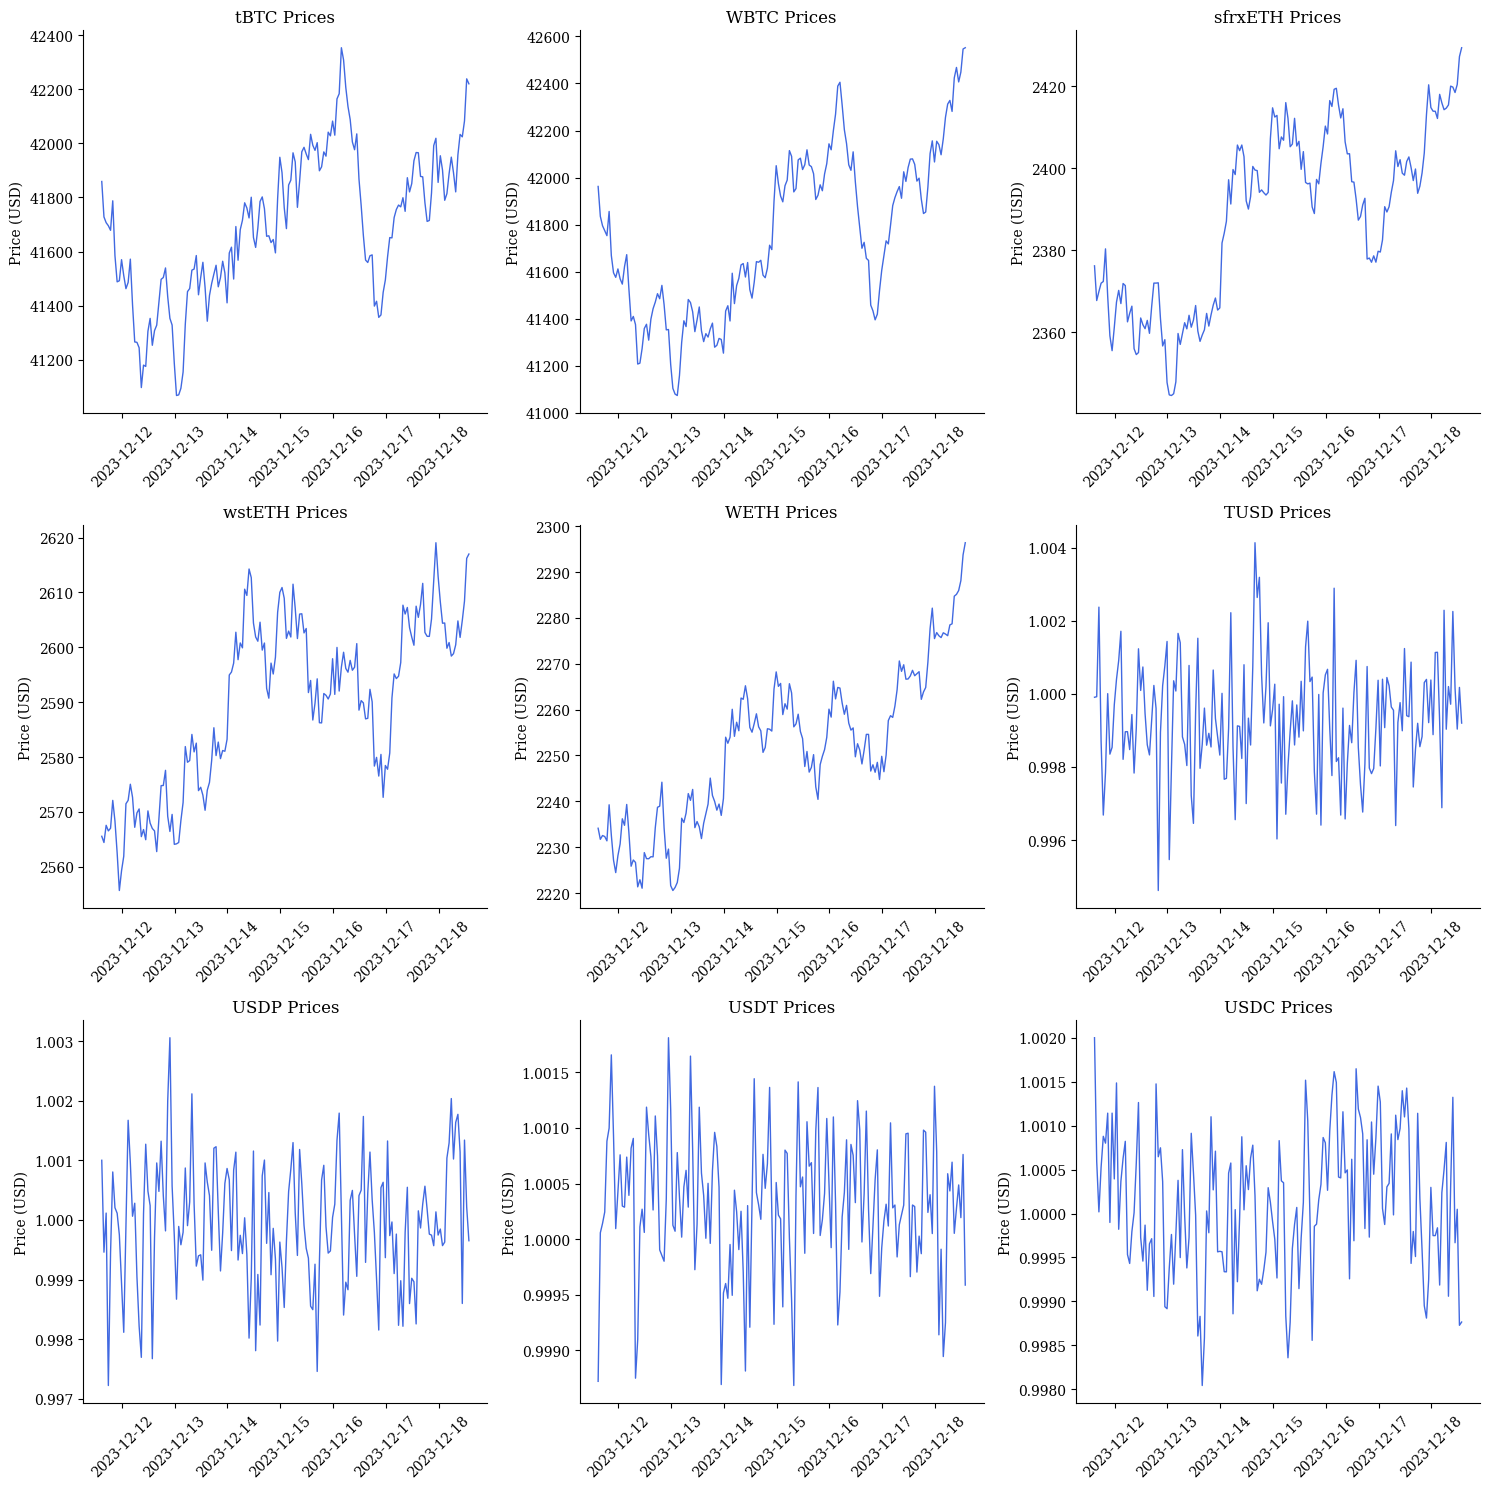

In [2]:
# Generate markets and prices
scenario = Scenario("baseline", "weth")
scenario.prepare_for_run()
_ = plot_prices(scenario.pricepaths.prices)
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

In [3]:
metricsprocessor = MetricsProcessor(scenario)
metricsprocessor.initial_state

{'timestamp': Timestamp('2023-12-11 14:48:19'),
 'arbitrageur_profit': 0,
 'arbitrageur_count': 0,
 'keeper_profit': 0.0,
 'keeper_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_count': 0,
 'llamma_WETH_price': 2144992556493953282869,
 'llamma_WETH_oracle_price': 2241251564014433468416,
 'llamma_WETH_fees_x': 0,
 'llamma_WETH_fees_y': 0,
 'llamma_WETH_bal_x': 4168251467043482107904,
 'llamma_WETH_bal_y': 15625548827036359639040,
 'controller_WETH_system_health': 3.824777952841526e+17,
 'controller_WETH_bad_debt': 6767869116229578480672768,
 'controller_WETH_num_loans': 264,
 'controller_WETH_debt': 22675979852758905487787250,
 'stableswap_crvUSD_TUSD_price': 1000536867242325838,
 'stableswap_crvUSD_TUSD_ma_price': 1000536867242325838,
 'stableswap_crvUSD_TUSD_lp_supply': 4402042031293157098893272,
 'stableswap_crvUSD_TUSD_virtual_price': 1000000000000000000,
 'stableswap_crvUSD_TUSD_TUSD_bal': 2487111603121784246660804,
 'stableswap_crvUSD_TUSD_crvUSD_bal': 191500590241377865495899

Text(0.5, 1.0, 'weth Loan Distribution')

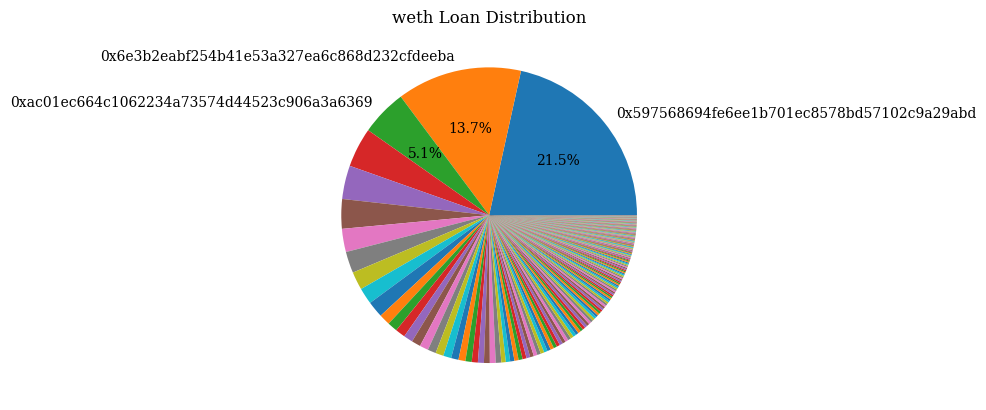

In [4]:
import matplotlib.pyplot as plt

def custom_autopct(pct):
    return '{:.1f}%'.format(pct) if pct > 5 else ''

controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else '' for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [8]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample) # update prices/timestamps
    scenario.perform_actions(sample) # arbitrage, liquidate, update
    metricsprocessor.update() # collect metrics

[INFO][14:53:29][src.agents.liquidator]-978140: There are 63 users to liquidate.
[INFO][14:53:29][src.agents.liquidator]-978140: Missed liquidation for user 0xf5e3eb47e8c4a110357fea6b1b366a0bfee75d20. Health: -56358433297015984.000000. Expected profit: -8962.449089.
[INFO][14:53:29][src.agents.liquidator]-978140: Missed liquidation for user 0xf47aa534208e7a3d5f950549f4606d92a9e10667. Health: -295261134973517952.000000. Expected profit: -4599.068270.
[INFO][14:53:29][src.agents.liquidator]-978140: Missed liquidation for user 0xee356446e8947832566b04cdaa5779fbd4950ab3. Health: -60420988269014520.000000. Expected profit: -1521.419223.
[INFO][14:53:29][src.agents.liquidator]-978140: Liquidating user 0xec718904654b29f1f571290259c324fd2e3aa63e with expected profit: 113488.053932.
[INFO][14:53:29][src.trades.cycle]-978140: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=USDT, out=crvUSD, amt=70427270394), Liquidation(controller=<crvusdsim.pool.sim_interfa

[INFO][14:53:29][src.trades.cycle]-978140: Executing trade Liquidation(controller=<crvusdsim.pool.sim_interface.sim_controller.SimController object at 0x7f82ecd885f0>, position=<crvusdsim.pool.crvusd.controller.Position object at 0x7f83042c7590>, amt=4506689301772215632250, frac=1000000000000000000, i=0, j=1).
[INFO][14:53:29][src.trades.cycle]-978140: Executing trade Swap(pool=External Market (WETH, USDT), in=Wrapped Ether, out=Tether USD, amt=2863127930898356343).
[INFO][14:53:29][src.agents.liquidator]-978140: Liquidated user 0x83b759d188e54da18716e4b108b8e580bb9da85b with profit: 1895.253458.
[INFO][14:53:29][src.agents.liquidator]-978140: Liquidating user 0x83786e8634813dbf45e305bb28b7fcf855d314a7 with expected profit: 13658.202137.
[INFO][14:53:29][src.trades.cycle]-978140: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=USDT, out=crvUSD, amt=8620797265), Liquidation(controller=<crvusdsim.pool.sim_interface.sim_controller.SimController object

In [19]:
df = metricsprocessor.df
df.to_csv("../data/results.csv")
df.head()

,timestamp,arbitrageur_profit,arbitrageur_count,keeper_profit,keeper_count,liquidator_profit,liquidator_count,llamma_WETH_price,llamma_WETH_oracle_price,llamma_WETH_fees_x,llamma_WETH_fees_y,llamma_WETH_bal_x,llamma_WETH_bal_y,controller_WETH_system_health,controller_WETH_bad_debt,controller_WETH_num_loans,controller_WETH_debt,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,aggregator_price,stablecoin_total_supply
0,2023-12-11 14:48:19,7017.781299,4,0.0,0,1.140214e+06,29,2221872987233359875262,2241251564014433468416,2443561,9177,309375983226325257472613,14335722229341375573361,4.471291e+17,5363599955535461600985088,235,21242809139952174114366805,1000536867242325838,1000536867242325838,4402042031293157098893272,1000000000000000000,2487111603121784246660804,1915005902413778654958999,999045132580566852,999334555797385850,3872601880239735243446188,1000001470670718222,1515590226872696751348763,2357208899386297634610762,998084470951778908,999152063301488020,34668174971355351997370401,1000004158097134916,11049341295912,23624216095499188681781287,1000349395064204414,999171526097520489,33975162557744240200094180,1000006970557721865,18452458950853,15523194361684064740962555,2799535340339654566214946,0,0,0,0,0,0,0,999186678096187831,304422947021902176369633560
1,2023-12-11 15:48:19,8631.181430,10,0.0,0,1.142327e+06,30,2219307149643702729726,2231866496269235982797,4412916,9177,652601629359511686669466,14132465474405644163404,4.435609e+17,5363599955535461600985088,234,21135844168138713045275919,1000148682271739416,1000271388789685799,4402042031293157098893272,1000002320787038677,2282775003058054992517428,2119283312715991731600441,999833329265792489,999395217216163777,3872601880239735243446188,1000005864034347760,1855744512182345561889819,2016886780532317944089146,998372307912349507,998151901411824216,34668174971355351997370401,1000005071544521189,11682013393084,22990454985853182736987771,1000271580329969838,1000298181579118954,33975162557744240200094180,1000007440824554907,18132881531989,15842688597111595221247926,2799535340339654566214946,0,0,0,0,0,0,0,999411697361713628,305396981543805085845262531
2,2023-12-11 16:48:19,10122.144443,16,0.0,0,1.142327e+06,30,2221274739248342508894,2232533999139024885679,6861141,9177,652601629359511686669466,14132465474405644163404,4.439674e+17,5363599955535461600985088,234,21135918404028108114333471,997807374205942011,998986164051965510,4402042031293157098893272,1000013090687701944,1335453296748175974118135,3067450370998821016574341,999833329265792489,999826474319441861,3872601880239735243446188,1000005864034347760,1855744512182345561889819,2016886780532317944089146,998908656732562240,998601739781861402,34668174971355351997370401,1000007165448126652,13132683026708,21537900554987242317639418,1000151009465962697,1000232186514953518,33975162557744240200094180,1000008183092109598,17628485548075,16347003338341595403053787,2799535340339654566214946,0,0,0,0,0,0,0,999391241289049449,306849463343317915312042292
3,2023-12-11 17:48:19,11520.153221,19,0.0,0,1.142327e+06,30,2220655094949596697928,2232330665433178140943,7906382,9

<Axes: >

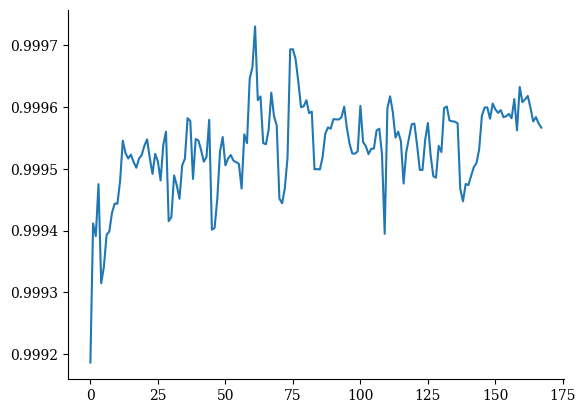

In [13]:
(df["aggregator_price"] / 1e18).plot()

<Axes: >

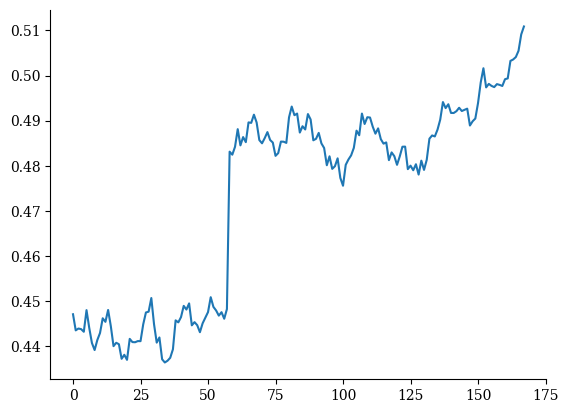

In [22]:
(df["controller_WETH_system_health"] / 1e18).plot()

<Axes: >

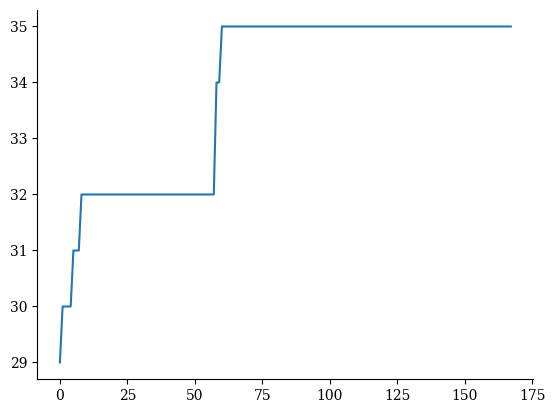

In [34]:
df["liquidator_count"].plot()

Notice that the above is a standard result from risk simulations: frequent, small liquidations actually *improve* the health of the system! 

In [37]:
df["llamma_WETH_price"].dtype
# df["llamma_WETH_oracle_price"].plot()

dtype('O')

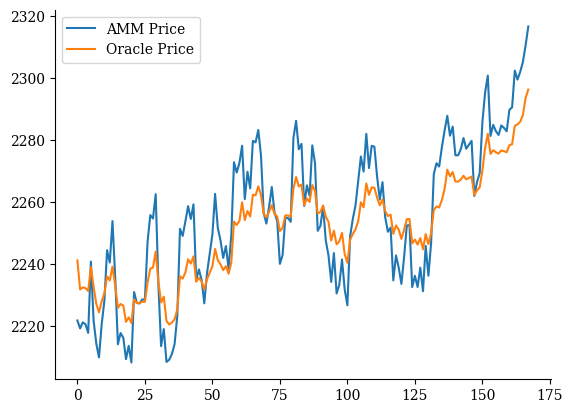

In [70]:
(df["llamma_WETH_price"]/1e18).plot(label="AMM Price")
(df["llamma_WETH_oracle_price"]/1e18).plot(label="Oracle Price") # = spot price for now
plt.legend()
# scenario.pricepaths.prices[SYMBOL_TO_ADDRESS["WETH"]].reset_index(drop=True).plot()

Text(0.5, 1.0, 'Profits sans t0')

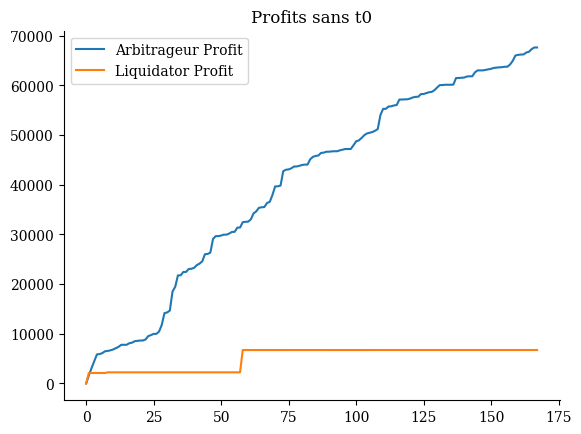

In [76]:
(df["arbitrageur_profit"] - df["arbitrageur_profit"].iloc[0]).plot(label="Arbitrageur Profit")
(df["liquidator_profit"] - df["liquidator_profit"].iloc[0]).plot(label="Liquidator Profit")
plt.legend()
plt.title("Profits sans t0")

<Axes: >

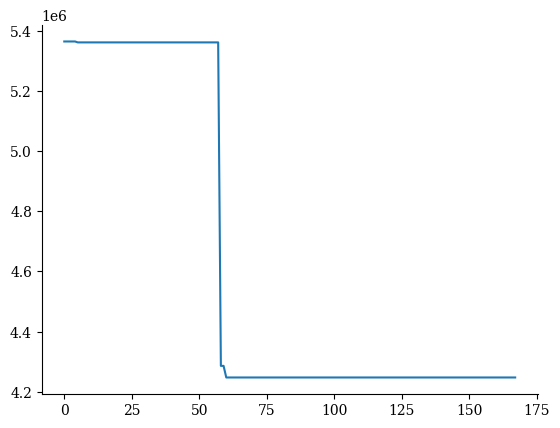

In [77]:
(df["controller_WETH_bad_debt"]/1e18).plot()

(1.0, 1.0005)

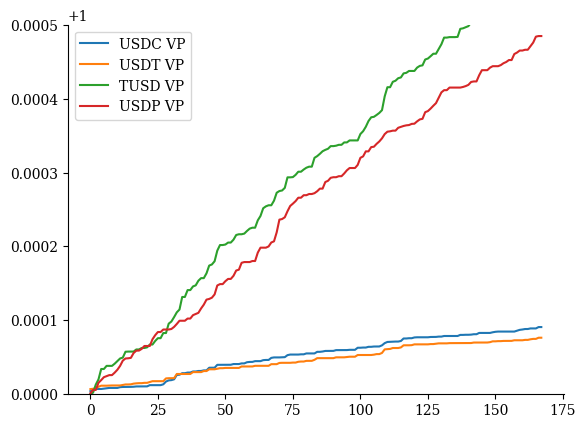

In [88]:
(df["stableswap_crvUSD_USDC_virtual_price"] / 1e18).plot(label="USDC VP")
(df["stableswap_crvUSD_USDT_virtual_price"] / 1e18).plot(label="USDT VP")
(df["stableswap_crvUSD_TUSD_virtual_price"] / 1e18).plot(label="TUSD VP")
(df["stableswap_crvUSD_USDP_virtual_price"] / 1e18).plot(label="USDP VP")
plt.legend()
plt.ylim(1, 1.0005)